# Tutorial of SIAC Filtering

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This tutorial by Xiaozhou Li is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.  
All code examples are also licensed under the [MIT license](http://opensource.org/licenses/MIT).

## What is SIAC Filtering
A standard definition of SIAC Filtering is a B-spline based convolution processing technique.  The name SIAC means Smoothness-Increasing Accuracy-Conserving.  The formulation can be written as
$$ u_h^{\star}(x, T) = (K_h\star u_h)(x, T) = \int_{-\infty}^{\infty}K_h(x - \xi)u_h(\xi, T) d\xi, $$
where $K_h$ is the so-called SIAC filter.

## A Review of B-spline
First, we recall the definition of B-splines given by de Boor \cite{Boor:2001}.

__B-spline__ 

Let $\mathbf{t}:= (t_j)$ be a __nondecreasing sequence__ of real numbers that create a so-called knot sequence. The $j$th B-spline of order $\ell$ for the knot sequence $\mathbf{t}$ is denoted by $B_{j,\ell,\mathbf{t}}$ and is defined, for $\ell=1$, by the rule
\begin{equation}
    B_{j,1,\mathbf{t}}(x) =
        \left\{\begin{array}{ll}
        1, & t_j \leq x < t_{j+1}; \\
        0, & \text{otherwise}.
        \end{array} \right.
\end{equation}
In particular, $t_j = t_{j+1}$ leads to $B_{j,1,\mathbf{t}} = 0.$ For $\ell > 1$,
\begin{align*}
 B_{j,\ell,\mathbf{t}}(x)
= \omega_{j,k,\mathbf{t}}B_{j,\ell-1,\mathbf{t}} +
(1 - \omega_{j+1,\ell,\mathbf{t}})B_{j+1,\ell-1,\mathbf{t}},
\end{align*}
with
$$ \omega_{j,\ell,\mathbf{t}}(x) = \frac{x-t_j}{t_{j+\ell-1}-t_{j}}.$$

- The knot sequence $\mathbf{t}$ also represents the so-called breaks of the B-spline. 
- The B-spline in the region $[t_i, t_{i+1}),\, i = 0,\ldots,\ell-1$ is a polynomial of degree $\ell-1$, but in the entire support $[t_0,t_{\ell}]$, the B-spline is a piecewise polynomial. 
- When the knots $(t_j)$ are sampled in a symmetric and equidistant fashion, the B-spline is called a central B-spline. 

__Central B-spline__

A central B-spline of order $\ell$ has a knot sequence that is uniformly spaced and symmetrically distributed 
$$\mathbf{t}=-\frac{\ell}{2},-\frac{\ell-2}{2},\cdots,\frac{\ell-2}{2},\frac{\ell}{2}.$$
For convenience, we denote $\psi_{\mathbf{t}}^{(\ell)}(x)$ to be the $0^{th}$ B-spline of order $\ell$ for the knot sequence $\mathbf{t}$, 
$$\psi_{\mathbf{t}}^{(\ell)}(x) = B_{0,\ell,\mathbf{t}}(x).$$



In [375]:
# environment setting, before any codes
import numpy as np
import numpy.polynomial.legendre as npleg
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output, display

### Implementing of B-splines
Here, we adopt de Boor's algorithm B-spline to implement B-spline
```python
    def bspline(x, order, T)
```
where
- $x$: the evaluation point 
- $order$: the order of B-spline (polynomial degree $= order-1$)
- $T$: $T[0], \ldots, T[order]$ the nodes b-spline
Note:
- One has to be careful once the evaluation point $x$ is located at the end nodes of the B-spline. It is the reason to introduce the $tiny$ variable$.

In [376]:
def bspline(x, order, T):
    tiny = 1.e-13
    if (x < T[0]-tiny or x > T[order]+tiny):
        return 0.
    else:
        if (np.abs(x - T[0])) < tiny:
            x = T[0] + 2*tiny
        if (np.abs(x - T[order])) < tiny:
            x = T[order] - 2*tiny 
        for i in range(order):
            if (x >= T[i]-tiny and x < T[i+1]-tiny):
                left = i
                break
        B1 = np.zeros(order+1)
        B1[left] = 1.
        for i in range(1,order):
            B2 = B1
            for j in range(0,order-i):
                if (B2[j] < tiny):
                    termL = 0.
                else:
                    termL = (x - T[j])/(T[i+j] - T[j])*B2[j]
                if (B2[j+1] < tiny):
                    termR = 0.
                else:
                    termR = (T[i+j+1] - x)/(T[i+j+1] - T[j+1])*B2[j+1]
                B1[j] = termL + termR
        return B1[0]

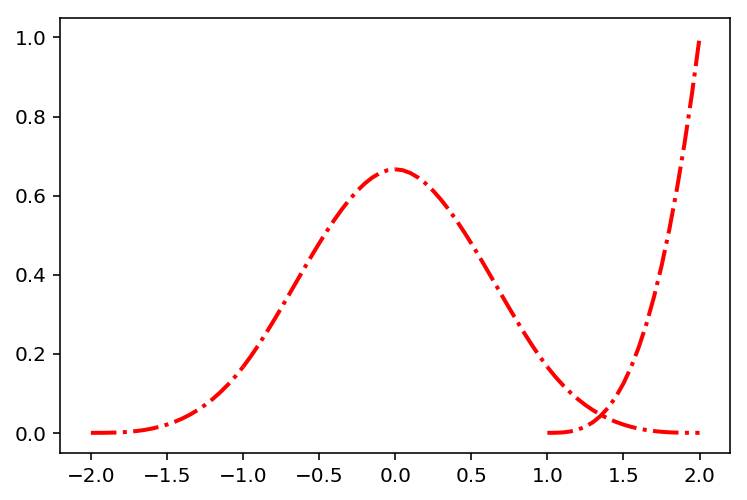

In [377]:
def plot_bspline(order,T):
    samples = 21
    tiny = 1.e-13
    for i in range(np.size(T)-1):
        if (np.abs(T[i] - T[i+1]) > tiny):
            x = np.linspace(T[i], T[i+1], samples)
            y = np.zeros(samples)
            for j in range(samples):
                y[j] = bspline(x[j], order, T)
            plt.plot(x, y,'-.r',linewidth=2)

order = 4
T1 = np.array([-2, -1, 0, 1, 2])
T2 = np.array([1, 2, 2, 2, 2])
plot_bspline(order,T1)
plot_bspline(order,T2)
plt.show()

## Construction of the Simplest SIAC Filter
In the early literatures like \cite{Bramble:1977} and \cite{Cockburn:2003}, the classic filter is defined as 
\begin{equation}
    K^{(2k+1,k+1)}(x) = \sum\limits_{\gamma=0}^{2k}c^{(2k+1,k+1)}_{\gamma}\psi^{(k+1)}\left(x - x_\gamma\right),
\end{equation}
where $x_\gamma = \gamma - k$ and $\psi^{(k+1)}$ is the $(k+1)$th order __central B-spline__.  The scaled filter used for filtering is given by
$$ K_h^{(2k+1,k+1)}(x) = \frac{1}{h}K^{(2k+1,k+1)}\left(\frac{x}{h}\right). $$
Here, we follow the extensions in \cite{Li:2015} for a more general framework
\begin{equation}
    K^{(r+1,\ell)}(x) = \sum\limits_{\gamma=0}^{r}c^{(r+1,\ell)}_{\gamma}\psi^{\ell}\left(x - \eta x_\gamma\right),
\end{equation}
where $x_\gamma = \eta\left(\gamma - \frac{r}{2}\right)$ and $\psi^{\ell}$ is the $\ell$th order __central B-spline__.  Furthermore, $r+1$ is the number of B-splines and $\eta$ is the compression factor.

### The nodes matrix 
To design a general framework to construct the filter, we introduce the concept of nodes matrix.  

__nodes matrix:__

A nodes matrix,  $T$, is an $(r+1) \times (\ell+1)$ matrix such that the $\gamma-$th row, $T[\gamma,:]$, of the matrix $T$ is a nodes sequence with $\ell+1$ elements that are used to create the B-spline $\psi_{T[\gamma,:]}^{\ell}(x)$.  The number of rows $r+1$ is specified based on the number of B-splines used to construct the filter. 

As we mensioned before, the $\ell$th order central B-spline has the nodes sequence 
$$\left[-\frac{\ell}{2},-\frac{\ell-2}{2},\cdots,\frac{\ell-2}{2},\frac{\ell}{2}\right],$$
which leads 
$$T[\gamma,:] = \eta x_\gamma + \left[-\frac{\ell}{2},-\frac{\ell-2}{2},\cdots,\frac{\ell-2}{2},\frac{\ell}{2}\right],$$
or
$$T[j, i] = i - \frac{\ell}{2} + \eta \left(j - \frac{r}{2}\right).$$

In [378]:
def generate_nodes_T(num, order, compress):
    T = np.zeros([num,order+1])
    for j in range(num):
        for i in range(order+1):
            T[j,i] = i - 0.5*order + compress*(j - 0.5*(num-1))
    return T
##k = 1
##print (generate_nodes_T(2*k+1, k+1, 1))

### Coefficient
After defined the B-splines used to construct the filter, the only thing remains is to decide the coefficient, $\left\{c^{(r+1,\ell)}_\gamma\right\}_{\gamma=0}^r$.  The coefficients are decided by implementing the property that the filter reproduces polynomials by convolution up to degree $r$, 
\begin{equation}
    K^{(r+1,\ell)} \star p = p, \quad p = 0, x, ..., x^{r}.
\end{equation}
Using the monomials as in the above equation we can obtain the following linear system for the filter coefficients:
\begin{equation}
    \sum\limits_{\gamma=0}^{r} c_\gamma^{(r+1,\ell)}\int_{-\infty}^\infty \psi^{(\ell)}(\xi - x_\gamma)(x - \xi)^m d\xi = x^m, \,\, m = 0, 1,\ldots,r.
\end{equation}
In order to calculate the integration exactly, we use Gaussian quadrature with $\lceil\frac{\ell+m+1}{2}\rceil$ quadrature points. As an example for $k=1$ ($r = 2k, \ell=k+1$), we have
\begin{equation}
    \label{eq-Matrix}
    \left[
        \begin{array}{ccc}
            1 & 1 & 1\\
            x-1& x & x+1 \\
            x^2+2x+\frac{7}{6} & x^2 + \frac{1}{6} & x^2-2x+\frac{7}{6}
        \end{array}
    \right]
    \left[
        \begin{array}{c}
            c_0 \\
            c_1 \\
            c_2 \\
        \end{array}
    \right]
    = 
    \left[
        \begin{array}{c}
            1 \\
            x \\ 
            x^2 \\
        \end{array}
    \right].
\end{equation}
Since this linear system holds for all $x$, we can simply set $x=0$ and obtain the coefficients $[c_0, c_1, c_2]^{T} = [ -\frac{1}{12}, \frac{7}{6}, -\frac{1}{12}]^T$.


In [379]:
def generate_coeff(num, order, T):
    Gpn = int(np.ceil(0.5*(num+order)))
    xg, wg = npleg.leggauss(Gpn)
    A = np.zeros([num,num])
    b = np.zeros([num])
    b[0] = 1.
    for i in range(num):
        for j in range(num):
            for l in range(order):
                xm = 0.5*(T[j,l] + T[j,l+1])
                xr = 0.5*(T[j,l+1] - T[j,l])
                for m in range(Gpn):
                    A[i,j] += xr*wg[m]*bspline(xm+xr*xg[m], \
                                               order, T[j,:])* \
                            (-xr*xg[m]-xm)**i
    c = np.linalg.solve(A,b)
    return c

In [380]:
def filter(x, num, order, T, c):
    sum = 0.
    for j in range(num):
        sum += c[j]*bspline(x, order, T[j,:])
    return sum

def plot_filter(num, order, T, c):
    samples = 1001
    x = np.linspace(T[0,0], T[num-1,order], samples)
    y = np.zeros(samples)
    for i in range(samples):
        y[i] = filter(x[i], num, order, T, c)
    plt.plot(x,y,'-k',linewidth=2)

In [399]:
def original_filter(degree):
    num = 2*degree + 1
    order = degree + 1

    T = generate_nodes_T(num, order, 1)
    c = generate_coeff(num, order, T)
    print ('Filter Coefficients:  ', c, '\n')
    #plt.figure(figsize=(10,6))
    for i in range(num):
        plot_bspline(order, T[i,:])
    plot_filter(num, order, T, c)
    plt.xlabel('$x$',fontsize=16)
    plt.ylabel('$K(x)$',fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Original Filter, $k = '+str(degree)+'$',fontsize=18)
    plt.show()

w = interactive(original_filter, degree=widgets.IntSlider(min=1,max=5,value=1))
display(w)

A Jupyter Widget

## Filtering


### DG Solution
In this tutorial, we do not include the DG codes.  Instead, we will input the DG solution, then apply the filtering.  In the default setting, the DG solution has form
\begin{equation}
    u_h(x) = \sum\limits_{j=1}^N\sum\limits_{l = 0}^k u_{l,j}\phi_j^l(x),
\end{equation}
where $\left\{\phi_j^l\right\}_{l=0}^k$ is the standard Legendre polynomial on the element $I_j = [x_{j-\frac{1}{2}},x_{j+\frac{1}{2}}]$.  Coefficients $\left\{u_{l,j}\right\}$ are provided by data file, $DGsolution\_k?\_N?.dat$, with column-major order ($l$-major).  This data is computed for the linear equation
\begin{equation*}
   u_t + u_x = 0
\end{equation*}
on the uniform mesh for domain $[0,1]$ with exact solution 
$$u(x,T) = \sin(2\pi(x-T))$$ 
at $T = 1$.

First of all, we define a function to read the DG data and return the coefficients $u[l,j]$
```python
    def Input_DG(EleNum, degree)
```
where
- $N$: the number of elements
- $k$: the polynomial degree of DG basis

In [382]:
def Input_DG(EleNum, degree):
    u = np.loadtxt("DGdata/DGsolution_k"+str(degree)+"_N"+str(EleNum)+".dat")
    return np.transpose(np.reshape(u,[EleNum,degree+1]))

Before we apply the filtering, let us have a look of the error of DG solutions.  To do so, we have to define the Legendre basis function
```python
    def LegendreBasis(x,degree)
```

In [383]:
def LegendreBasis(x, degree):
    coeff = np.zeros(degree+1)
    coeff[degree] = 1.
    return npleg.legval(x, coeff)

In [384]:
def print_OrderTable(number_coarse, erri, err2):
    print ("  N  Linf norm order  L2 norm  order")
    for i in range(np.size(erri)):
        N = number_coarse*2**i
        if (i == 0):
            print ("%3d  %7.2e   --   %7.2e   --" % \
                   (N, erri[i], err2[i]))
        else:
            print ("%3d  %7.2e  %4.2f  %7.2e  %4.2f" % \
                       (N, \
                        erri[i], np.log(erri[i-1]/erri[i])/np.log(2),\
                        err2[i], np.log(err2[i-1]/err2[i])/np.log(2)))

In [385]:
def DG_order(number_coarse, degree):
    Gpn = 6
    xg, wg = npleg.leggauss(Gpn)
    err2 = np.zeros(4)
    erri = np.zeros(4)
    style = ['b.','g-.','r--','c-']
    
    for i in range(4):
        N = number_coarse*2**(i)
        u = Input_DG(N, degree)
        x = np.linspace(0, 1, N+1)
        dx = np.diff(x)
        ## plotting
        plot_x = np.empty(N*Gpn)
        plot_y = np.empty(N*Gpn)
        
        for j in range(N):
            for m in range(Gpn):
                uh = 0.
                xj = (x[j+1]+x[j])/2 + dx[j]*xg[m]/2
                for l in range(degree+1):
                    uh += u[l,j]*LegendreBasis(xg[m], l)
                err = np.abs(np.sin(2*np.pi*xj)-uh)
                err2[i] += 0.5*dx[j]*wg[m]*err**2
                erri[i] = max(erri[i], err)
                
                plot_x[j*Gpn+m] = xj
                plot_y[j*Gpn+m] = err
        err2[i] = np.sqrt(err2[i]/1.)
        plt.plot(plot_x, plot_y, style[i],linewidth=2.0, label="N = " + str(N))
    print_OrderTable(number_coarse, erri, err2)
    plt.yscale('log')
    ax = plt.legend(fontsize=14)
    ax.draw_frame(False)
    plt.xlim(0, 1)
    #plt.ylim(1.e-6,1.e0)
    plt.xlabel('x',fontsize=18)
    plt.ylabel('|error|',fontsize=18)
    plt.show()

#DG_order(20, 3)
w = interactive(DG_order, number_coarse=fixed(20), degree=widgets.IntSlider(min=1,max=4,value=1))
display(w)

A Jupyter Widget

__Note:__ 
    
Actually, one can use numpy function
```python
    numpy.polynomial.legendre.legval(x, u[0:degree+1,j])
```
to evaluate $u_h$ directly.  In fact, as a post-processing technique, there is no need to know the basis functions information of the DG solution.  One only needs to know the evaluation of $u_h(x)$. Of course, in order to calculate the convolution properly, we still need the mesh information of the DG method.    

In [386]:
def point_location(x, grid):
    tiny = 1.e-10
    # assume periodic condition
    x = np.mod(x, 1)
    for n in range(np.size(grid)-1):
        if (grid[n] - tiny <= x and x <= grid[n+1] -tiny):
            return n
    return np.size(grid)-2

def u_DG(x, element_index, u):
    return npleg.legval(x, u[:,element_index])

In [387]:
def DG_order(number_coarse, degree):
    Gpn = 6
    xg, wg = npleg.leggauss(Gpn)
    err2 = np.zeros(4); erri = np.zeros(4)
    style = ['b.','g-.','r--','c-']
    
    for ii in range(4):
        N = number_coarse*2**(ii)
        u = Input_DG(N, degree)
        x = np.linspace(0, 1, N+1)
        dx = np.diff(x)
        ## plotting
        plot_x = np.empty(N*Gpn); plot_y = np.empty(N*Gpn)
        
        for j in range(N):
            for m in range(Gpn):
                xj = (x[j+1]+x[j])/2 + dx[j]*xg[m]/2
                #uh = u_DG(xg[m], point_location(xj,x), u)
                uh = u_DG(xg[m], j, u)
                err = np.abs(np.sin(2*np.pi*xj)-uh)
                err2[ii] += 0.5*dx[j]*wg[m]*err**2
                erri[ii] = max(erri[ii], err)
                
                plot_x[j*Gpn+m] = xj; plot_y[j*Gpn+m] = err
        err2[ii] = np.sqrt(err2[ii]/1.)
        plt.plot(plot_x, plot_y, style[ii],linewidth=2.0, label="N = " + str(N))
    print_OrderTable(number_coarse, erri, err2)
    
    plt.yscale('log')
    ax = plt.legend(fontsize=14); ax.draw_frame(False)
    plt.xlim(0, 1); #plt.ylim(1.e-6,1.e0)
    plt.xlabel('x',fontsize=18); plt.ylabel('|error|',fontsize=18)
    plt.show()

#DG_order(20, 3)
w = interactive(DG_order, number_coarse=fixed(20), degree=widgets.IntSlider(min=1,max=4,value=2))
display(w)

A Jupyter Widget

### Evaluation of the Convolution 
$$ u_h^{\star}(x, T) = (K_H\star u_h)(x, T) = \int_{-\infty}^{\infty}K_H(x - \xi)u_h(\xi, T) d\xi, $$
The basic operation used in SIAC filtering is convolution of the DG solution against a B-spline based filter. Here, we explicitly point out the steps to efficient evaluation of the convolution operator.  In the one-dimensional case, denote $\{I_j\}_{j=1}^N$ be the mesh of the DG solution.
*  To calculate the integration, we first need to specify the support range.  The support size of the filter is decided by its nodes matrix $T$ that $\text{K(x)} = \left[\min{T}, \max{T}\right]$.  Therefore, to evaluate the filtered solution at the point $x \in I_j$, we have 
\begin{equation}
    \begin{split}
    u_h^\star(x) & = \frac{1}{H}\int_{-\infty}^\infty K^{(r,\ell)}\left(\frac{x - \xi}{H}\right)u_h(\xi) d\xi \\
               & = \frac{1}{H}\int_{x - H\cdot\max\{T\}}^{x- H\cdot\min\{T\}}K^{(r,\ell)}\left(\frac{x-\xi}{H}\right)u_h(\xi) d\xi
    \end{split}
\end{equation}

* The above integration is calculated by Gauss quadrature with at least $k+1$ quadrature points.  However, both the DG solution and the filter are piecewise polynomials.  Therefore, we have to divide the integration interval, $\left[x - H\cdot\max\{T\}, x- H\cdot\min\{T\}\right]$ into many subintervals, such that both the DG solution and the filter are polynomials on each subinterval.  
    - First, find the DG elements that involved in the integration, that 
        $$A(x) = \left\{i:\quad I_i \cap \left[x - H\cdot\max\{T\}, x- H\cdot\min\{T\}\right] \neq \varnothing \right\},$$
        then we write the integration as  
        $$u_h^\star(x) = \frac{1}{H}\sum\limits_{i \in A(x)} \int_{I_{i}}K^{(r,\ell)}\left(\frac{x-\xi}{H}\right)u_h(\xi) d\xi. $$
    - Then we divide the elements $I_i$ into several subintervals that $I_i = \bigcup\limits_{\alpha=1}^{n_{i}}I_{i}^\alpha$ according to the breaks of the filter such that on each subinterval $I_{i}^\alpha$ the filter is a polynomial, it leads
\begin{equation}
    \begin{split}
        & \int_{I_{i}}K^{(r,\ell)}\left(\frac{x-\xi}{H}\right)u_h(\xi) d\xi \\
        = &\, \sum\limits_{\alpha=1}^{n_{i}}\int_{I_{i}^\alpha}K^{(r,\ell)}\left(\frac{x-\xi}{H}\right)u_h(\xi) d\xi.
    \end{split}
\end{equation}
    - Finally, we can apply the Gauss quadrature to calculate the integration on subintervals $I_{i}^\alpha$.

__Note:__ 
* For uniform meshes, we usually choose the uniform element size $h$ as the filter scaling, $H = h$.  Therefore, we only need to divide each element $I_{i}$ into two subintervals. 
* For nonuniform meshes, the scaling and the number of subintervals is dependent on the mesh. To speed up the filtering process, sometimes it is possible to use inexact integration.  However, first step is necessary. 
* In multi-dimensions, the filter is a tensor product of the one-dimensional filters. The implementation of the multi-dimensional SIAC filter over rectangular meshes is the same. For triangular meshes, the principles are the same and one can find the details in another [notebook]().

### Step by Step Python Implementation
In previous section, we have discussed the algorithm Now, let us implementing the filtering step by step.

* __Filter Nodes__ 
```python
    def generate_filter_nodes(T):
            ---
        return filter_nodes
```
the $filter\_nodes$ stores all the nodes of the filter, which is the union of the nodes of all used B-splines.
    - Be aware that the nodes may be float numbers, it is not safe to use np.unique directly.

In [388]:
def generate_filter_nodes(T):
    tiny = 1.e-13
    filter_nodes = np.array([np.min(T), np.max(T)])
    for j in range(np.size(T,axis=0)):
        for i in range(np.size(T,axis=1)):
            for m in range(np.size(filter_nodes)):
                if (np.abs(filter_nodes[m] - T[j,i]) < tiny):
                    break
                if (filter_nodes[m] - T[j,i] > tiny):
                    filter_nodes = np.insert(filter_nodes, m, T[j,i])
                    break
    return filter_nodes

* __Involved DG Elements__
```python 
    def generate_index_Ax(x, grid, T, H):
            ---
        return Ax
```
This function will return the index of the elements which are involved for filtering point $x$,
$$A(x) = \left\{i:\quad I_i \cap \left[x - H\cdot\max\{T\}, x- H\cdot\min\{T\}\right] \neq \varnothing \right\}.$$
    - If $x$ is near the boundary, the above support interval may not totally belong to the DG domain.  In this situation, the index returned will processed by periodic assumption.  

In [389]:
def generate_index_Ax(x, grid, T, H):
    left_index  = point_location(x - H*np.max(T), grid)
    right_index = point_location(x - H*np.min(T), grid)
    if (left_index <= right_index):
        Ax = np.arange(left_index, right_index+1)
    else: #near boundary
        Ax = np.concatenate([np.arange(left_index, np.size(grid)-1),np.arange(right_index+1)])
    return Ax

* __Subintervals for Quadrature__
```python 
    def generate_subintervals_local(i, grid, filter_nodes):
            ---
        return interfaces
```
With the given DG element index $i$, this function will divide element $I_i$ into subintervals according to the $filter_nodes$.  It returns the interfaces of all the subintervals which are also the subintervals for using Gauss quadrature to compute the integration. 

In [390]:
def generate_subintervals_local(i, grid, filter_nodes):
    interfaces = np.array([grid[i],grid[i+1]])
    for j in range(np.size(filter_nodes)):
        if (grid[i] < filter_nodes[j] and filter_nodes[j] < grid[i+1]):
            interfaces = np.insert(interfaces, -1, filter_nodes[j])
    return interfaces

* __Computing the Convolution__
```python 
    def Gauss_convolution_filter_DG(xj, T, c, filter_nodes, H, grid, u, xg, wg):
            ---
        return ustar
```
Now, we have all the ingredients to calculate the convolution of the filter and the DG solution, let us put them together.  
    - One important reminder is that the support interval of the convolution operator has been processed periodically, so the evaluation of the filter value need to be processed in the same way too.
    - The filter coefficients $c$ and nodes $filter\_nodes$ can be computed from the node matrix $T$ directly.  However, they are fixed in this tutorial, so one can calculate them before and store the values. 
    - Also, the gauss quadrature points $xg$ and weight $wg$ can be either provided by outside of the function, or defined inside the function.  Whatever, to calculate the integration exactly, the points number should $\geq degree+1$.

In [391]:
def Gauss_convolution_filter_DG(xj, T, c, filter_nodes, H, grid, u, xg, wg):
    Ax = generate_index_Ax(xj, grid, T, H)
    filter_nodes_local = np.mod(xj - H*filter_nodes,1)
    num = np.size(T, axis=0)
    order = np.size(T, axis=1)-1
    N = np.size(grid)-1
    
    ustar = 0.
    for j in range(np.size(Ax)):
        i = Ax[j]
        h = grid[i+1] - grid[i]
        interfaces = generate_subintervals_local(i, grid, filter_nodes_local)
        for alpha in range(np.size(interfaces)-1):
            mid   = 0.5*(interfaces[alpha] + interfaces[alpha+1])
            scale = 0.5*(interfaces[alpha+1] - interfaces[alpha])
            for mm in range(np.size(xg)):
                quad_x = mid + scale*xg[mm]
                filter_x = (xj - quad_x)/H
                if (filter_x < np.min(T)):
                    filter_x += N
                elif (filter_x > np.max(T)):
                    filter_x += -N
                ustar += scale*wg[mm]*filter(filter_x, num, order, T, c)*\
                    u_DG((2*quad_x - (grid[i]+grid[i+1]))/h, i, u)
    return 1/H*ustar

In [392]:
def generate_filter(degree):
    num = 2*degree+1
    order = degree+1
    
    T = generate_nodes_T(num, order, 1)
    c = generate_coeff(num, order, T)
    filter_nodes = generate_filter_nodes(T)
    
    return T, c, filter_nodes

### Filtered Solution
Now, we have implemented the filtering, let us see the performance.

__Note:__ Due to the precision issue, in this tutorial, the filtered results for $N = 160$ with $\mathbb{P}^3$ polynomials and $N = 80, 160$ with $$\mathbb{P}^4$ polynomials are contaminated.  Since NumPy does not provide a data type with more precision than C long doubles, we will not addressed this issue in this tutorial.  However, we believe it is already enough for a demonstration purpose. 

In [393]:
def Filter_order(number_coarse, degree):
    # gauss points for plotting, computing norm error 
    Gpn = 6
    xg, wg = npleg.leggauss(Gpn)
    # gauss points for computing convolution, the number should >= degree+1
    Gpn2 = degree+1
    xg2, wg2 = npleg.leggauss(Gpn2)
    levels=4; err2 = np.zeros(4); erri = np.zeros(4);
    # plotting style
    style = ['b.','g-.','r--','c-']
    
    # generating the filter
    T, c, filter_nodes = generate_filter(degree)
    
    for i in range(levels):
        N = number_coarse*2**(i)
        u = Input_DG(N, degree)
        x = np.linspace(0, 1, N+1)
        dx = np.diff(x)
        
        # plotting
        plot_x = np.empty(N*Gpn); plot_y = np.empty(N*Gpn); 
        
        for j in range(N):
            H = dx[j]
            for m in range(Gpn):
                xj = (x[j+1]+x[j])/2 + dx[j]*xg[m]/2
                
                ustar = Gauss_convolution_filter_DG(xj, T, c, filter_nodes, H, x, u, xg2, wg2)
                
                err = np.abs(np.sin(2*np.pi*xj)-ustar)
                err2[i] += 0.5*dx[j]*wg[m]*err**2
                erri[i] = max(erri[i], err)
                # plotting
                plot_x[j*Gpn+m] = xj; plot_y[j*Gpn+m] = err
        err2[i] = np.sqrt(err2[i]/1.)
        plt.plot(plot_x, plot_y, style[i],linewidth=2.0, label="N = " + str(N))
    print_OrderTable(number_coarse, erri, err2)
    
    plt.yscale('log')
    plt.legend(loc=3,frameon=False, fontsize=14); 
    plt.xlim(0, 1); #plt.ylim(1.e-6,1.e0)
    plt.xlabel('x',fontsize=18); plt.ylabel('|error|',fontsize=18)
    plt.show()

#Filter_order(20, 2)
w = interactive(Filter_order, number_coarse=fixed(20), degree=widgets.IntSlider(min=1,max=4,value=2))
display(w)

A Jupyter Widget

### DG Solution vs. Filtered Solution
During previous sections, one can already see the advantages of the filtered solution over the DG solution.  Here, to give a easier view, we put the results together for comparison.

In [394]:
def DGvsFilter_order(number_coarse, degree):
    # gauss points for plotting, computing norm error 
    Gpn = 6
    xg, wg = npleg.leggauss(Gpn)
    # gauss points for computing convolution, the number should >= degree+1
    Gpn2 = degree+1
    xg2, wg2 = npleg.leggauss(Gpn2)
    levels=4; err2_dg = np.zeros(4); erri_dg = np.zeros(4); err2_filter = np.zeros(4); erri_filter = np.zeros(4)
    
    # plotting style
    style = ['b.','g-.','r--','c-']
    fig = plt.figure(figsize=(10,4))
    fig.tight_layout()
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    
    # generating the filter
    T, c, filter_nodes = generate_filter(degree)
    
    for i in range(levels):
        N = number_coarse*2**(i)
        u = Input_DG(N, degree)
        x = np.linspace(0, 1, N+1)
        dx = np.diff(x)
        
        # plotting
        plot_x = np.empty(N*Gpn); plot_dg = np.empty(N*Gpn); plot_filtered = np.empty(N*Gpn)
        
        for j in range(N):
            H = dx[j]
            for m in range(Gpn):
                xj = (x[j+1]+x[j])/2 + dx[j]*xg[m]/2
                
                uh = u_DG(xg[m], j, u)
                ustar = Gauss_convolution_filter_DG(xj, T, c, filter_nodes, H, x, u, xg2, wg2)
                
                err_dg = np.abs(np.sin(2*np.pi*xj)-uh)
                err_filter = np.abs(np.sin(2*np.pi*xj)-ustar)
                
                err2_dg[i] += 0.5*dx[j]*wg[m]*err_dg**2
                erri_dg[i] = max(erri_dg[i], err_dg)
                err2_filter[i] += 0.5*dx[j]*wg[m]*err_filter**2
                erri_filter[i] = max(erri_filter[i], err_filter)
                # plotting
                plot_x[j*Gpn+m] = xj; plot_dg[j*Gpn+m] = err_dg; plot_filtered[j*Gpn+m] = err_filter;
        err2_dg[i] = np.sqrt(err2_dg[i]/1.)
        erri_dg[i] = np.sqrt(erri_dg[i]/1.)
        if (i == 0):
            y_max = np.max(plot_dg)
        if (i == levels-1):
            y_min = np.min(plot_filtered)
        ax1.plot(plot_x, plot_dg, style[i],linewidth=2.0, label="N = " + str(N))
        ax2.plot(plot_x, plot_filtered, style[i],linewidth=2.0, label="N = " + str(N))
    print ("DG error: ")
    print_OrderTable(number_coarse, erri_dg, err2_dg)
    print ("\nFiltered error: ")
    print_OrderTable(number_coarse, erri_filter, err2_filter)
    
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.legend(frameon=False,fontsize=12)
    ax2.legend(frameon=False,fontsize=12)
    ax1.set_xlim(0, 1); ax1.set_ylim(y_min,y_max)
    ax2.set_xlim(0, 1); ax2.set_ylim(y_min,y_max)
    ax1.set_xlabel('x',fontsize=16); ax1.set_ylabel('|error|',fontsize=16)
    ax2.set_xlabel('x',fontsize=16); ax2.set_ylabel('|error|',fontsize=16)
    ax1.set_title('DG errors, degree = %1d' % degree, fontsize=16)
    ax2.set_title('Filtered errors, degree = %1d' % degree, fontsize=16)
    plt.show()

#DGvsFilter_order(20, 1)
w = interactive(DGvsFilter_order, number_coarse=fixed(20), degree=widgets.IntSlider(min=1,max=4,value=2))
display(w)

A Jupyter Widget

### Efficiency 
This tutorial is written for demonstration the idea, so the codes are not optimized for computing speed.  However, we note that if one has a look at the main function 
```python 
    Gauss_convolution_filter_DG(xj, T, c, filter_nodes, H, grid, u, xg, wg)
```
Clearly, for computing the filtered solution at different points, it does not need information from the filtered solution.  In other word, if one has an ideal parallel computing resource, the computational time of evaluating massive nodes will equal to evaluating a node, which is negligible. 

## Features of SIAC Filtering

## A Code to Play
In the end, we provide a code you can play with your own codes to see how the filtering can improve your results.  It does not matter you are using the DG codes, FEM codes, IGA codes, FVM codes, etc., the code should still work.  However, the performance may be varying according to the methods (the best performance comes from the DG methods).  We will discuss the difference in another [notebook](), but it is interesting to test your code to see what happens. 

For the following codes, you need provide the data of your numerical solutions, the grid, the number of elements, degree of the basis functions and a nodes sequence that you want to improve.  __Note:__ you may have to change the either the following code or your data structure a little bit. 

In [395]:
def Filtering(N, degree, nodes):
    # gauss points for computing convolution, the number should >= degree+1 
    Gpn = degree+1
    xg, wg = npleg.leggauss(Gpn)
    err_dg = np.zeros(np.size(nodes)); err_filtered = np.zeros(np.size(nodes)); 
    
    # generating the filter
    T, c, filter_nodes = generate_filter(degree)
    
    for i in range(np.size(nodes)):
        u = Input_DG(N, degree)
        x = np.linspace(0, 1, N+1)
        dx = np.diff(x)
        
        xj = nodes[i]
        j = point_location(xj, x)
        
        # original numerical solution
        uh = u_DG((2*xj - (x[j+1]+x[j]))/dx[j], j, u)
        err_dg[i] = np.abs(np.sin(2*np.pi*xj)-uh)
        
        # filtered solution
        H = dx[j]
        ustar = Gauss_convolution_filter_DG(xj, T, c, filter_nodes, H, x, u, xg, wg)   
        err_filtered[i] = np.abs(np.sin(2*np.pi*xj)-ustar)
                

    plt.plot(nodes, err_dg, 'k-.',linewidth=2.0, label="DG error")
    plt.plot(nodes, err_filtered, 'r-.',linewidth=2.0, label="Filtered error")
    print ("The maximum error at the given nodes: ")
    print ("DG error:        %7.2e" %  np.max(err_dg))
    print ("Filtered error:  %7.2e" %  np.max(err_filtered))

    plt.yscale('log')
    plt.xlim(0, 1)
    plt.legend(frameon=False,fontsize=12)
    plt.xlabel('x',fontsize=16)
    plt.ylabel('|error|',fontsize=16)
    plt.show()

__ A test example:__

The following code will generate the nodes sequence by all the Gauss-Legendre points on each elements.  __Note:__ the default dates come with this tutorial only support $N = 20, 40, 80, 160$ and $degree = 1, 2, 3, 4$.

In [396]:
def Filtering_Gauss(N, degree, Gpn):
    xg,_ = npleg.leggauss(Gpn)
    nodes = np.zeros(N*Gpn)
    grid = np.linspace(0, 1, N+1)
    for i in range(N):
        nodes[Gpn*i:Gpn*(i+1)] = 0.5*(grid[i+1]+grid[i]) + 0.5*xg*(grid[i+1]-grid[i])
    Filtering(N, degree, nodes)

w = interactive(Filtering_Gauss, \
                N=widgets.IntText(value=40, description='Number of Elements:', diaabled=False), \
                degree=widgets.IntText(value=2,description='Degree:', disabled=False), \
                Gpn=widgets.IntText(value=6, description='Gauss Points:', disabled=False))
display(w)

A Jupyter Widget

# References

(<a id="cit-Boor:2001" href="#call-Boor:2001">de Boor, 2001</a>) Carl de Boor, ``_A practical guide to splines_'',  2001.

(<a id="cit-Bramble:1977" href="#call-Bramble:1977">Bramble and Schatz, 1977</a>) Bramble J. H. and Schatz A. H., ``_Higher order local accuracy by averaging in the finite element
              method_'', Math. Comp., vol. 31, number 137, pp. 94--111,  1977.

(<a id="cit-Cockburn:2003" href="#call-Cockburn:2003">Cockburn, Luskin <em>et al.</em>, 2003</a>) Cockburn Bernardo, Luskin Mitchell and Shu Endre, ``_Enhanced accuracy by post-processing for finite element
              methods for hyperbolic equations_'', Math. Comp., vol. 72, number 242, pp. 577--606,  2003.  [online](http://dx.doi.org/10.1090/S0025-5718-02-01464-3)

(<a id="cit-Li:2015" href="#call-Li:2015">Li, 2015</a>) Xiaozhou Li, ``_Smoothness-Increasing and Accuracy-Conserving (SIAC) Filters for Discontinuous Galerkin Methods._'',  2015.